# Estimate the parameters of the Lorenz system from the dataset

@finmod

Note: If data is generated with a fixed time step method and then is tested against with the same time step, there is a biased introduced since it's no longer about hitting the true solution, rather it's just about retreiving the same values that the ODE was first generated by! Thus this version uses adaptive timestepping for all portions so that way tests are against the true solution.

In [16]:
using ParameterizedFunctions, OrdinaryDiffEq, DiffEqParamEstim
using BlackBoxOptim, NLopt, Plots
gr(fmt=:png)

Plots.GRBackend()

In [2]:
Xiang2015Bounds = Tuple{Float64, Float64}[(9, 11), (20, 30), (2, 3)] # for local optimizations
xlow_bounds = [9.0,20.0,2.0]
xhigh_bounds = [11.0,30.0,3.0]
LooserBounds = Tuple{Float64, Float64}[(0, 22), (0, 60), (0, 6)] # for global optimization
GloIniPar = [0.0, 0.5, 0.1] # for global optimizations
LocIniPar = [9.0, 20.0, 2.0] # for local optimization

3-element Array{Float64,1}:
  9.0
 20.0
  2.0

In [4]:
g1 = @ode_def_bare LorenzExample begin
  dx = σ*(y-x)
  dy = x*(ρ-z) - y
  dz = x*y - β*z
    end σ=>10.0 ρ=>28.0 β=>2.66    # Parameters used to construct the dataset

r0 = [1.0; 0.0; 0.0]                #[-11.8,-5.1,37.5] PODES Initial values of the system in space # [0.1, 0.0, 0.0]
tspan = (0.0, 30.0)                 # PODES sample of 3000 observations over the (0,30) timespan
prob = ODEProblem(g1, r0, tspan)
tspan2 = (0.0, 3.0)                 # Xiang test sample of 300 observations with a timestep of 0.01
prob_short = ODEProblem(g1, r0, tspan2)

DiffEqBase.ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 3.0)
u0: [1.0, 0.0, 0.0]

In [5]:
dt = 30.0/3000                    
tf = 30.0
tinterval = 0:dt:tf
t  = collect(tinterval)

3001-element Array{Float64,1}:
  0.0 
  0.01
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  0.1 
  0.11
  0.12
  ⋮   
 29.89
 29.9 
 29.91
 29.92
 29.93
 29.94
 29.95
 29.96
 29.97
 29.98
 29.99
 30.0 

In [6]:
h = 0.01
M = 300
tstart = 0.0
tstop = tstart + M * h
tinterval_short = 0:h:tstop
t_short = collect(tinterval_short)

301-element Array{Float64,1}:
 0.0 
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1 
 0.11
 0.12
 ⋮   
 2.89
 2.9 
 2.91
 2.92
 2.93
 2.94
 2.95
 2.96
 2.97
 2.98
 2.99
 3.0 

In [7]:
# Generate Data
data_sol_short = solve(prob_short,Vern9(),saveat=t_short,reltol=1e-9,abstol=1e-9)
data_short = convert(Array, data_sol_short) # This operation produces column major dataset obs as columns, equations as rows
data_sol = solve(prob,Vern9(),saveat=t,reltol=1e-9,abstol=1e-9)
data = convert(Array, data_sol)

3×3001 Array{Float64,2}:
 1.0  0.917924    0.867919    0.84536     …  13.8987   13.2896   12.5913 
 0.0  0.26634     0.51174     0.744654        8.31875   6.71989   5.22868
 0.0  0.00126393  0.00465567  0.00983655     39.19     39.1699   38.904  

Plot the data


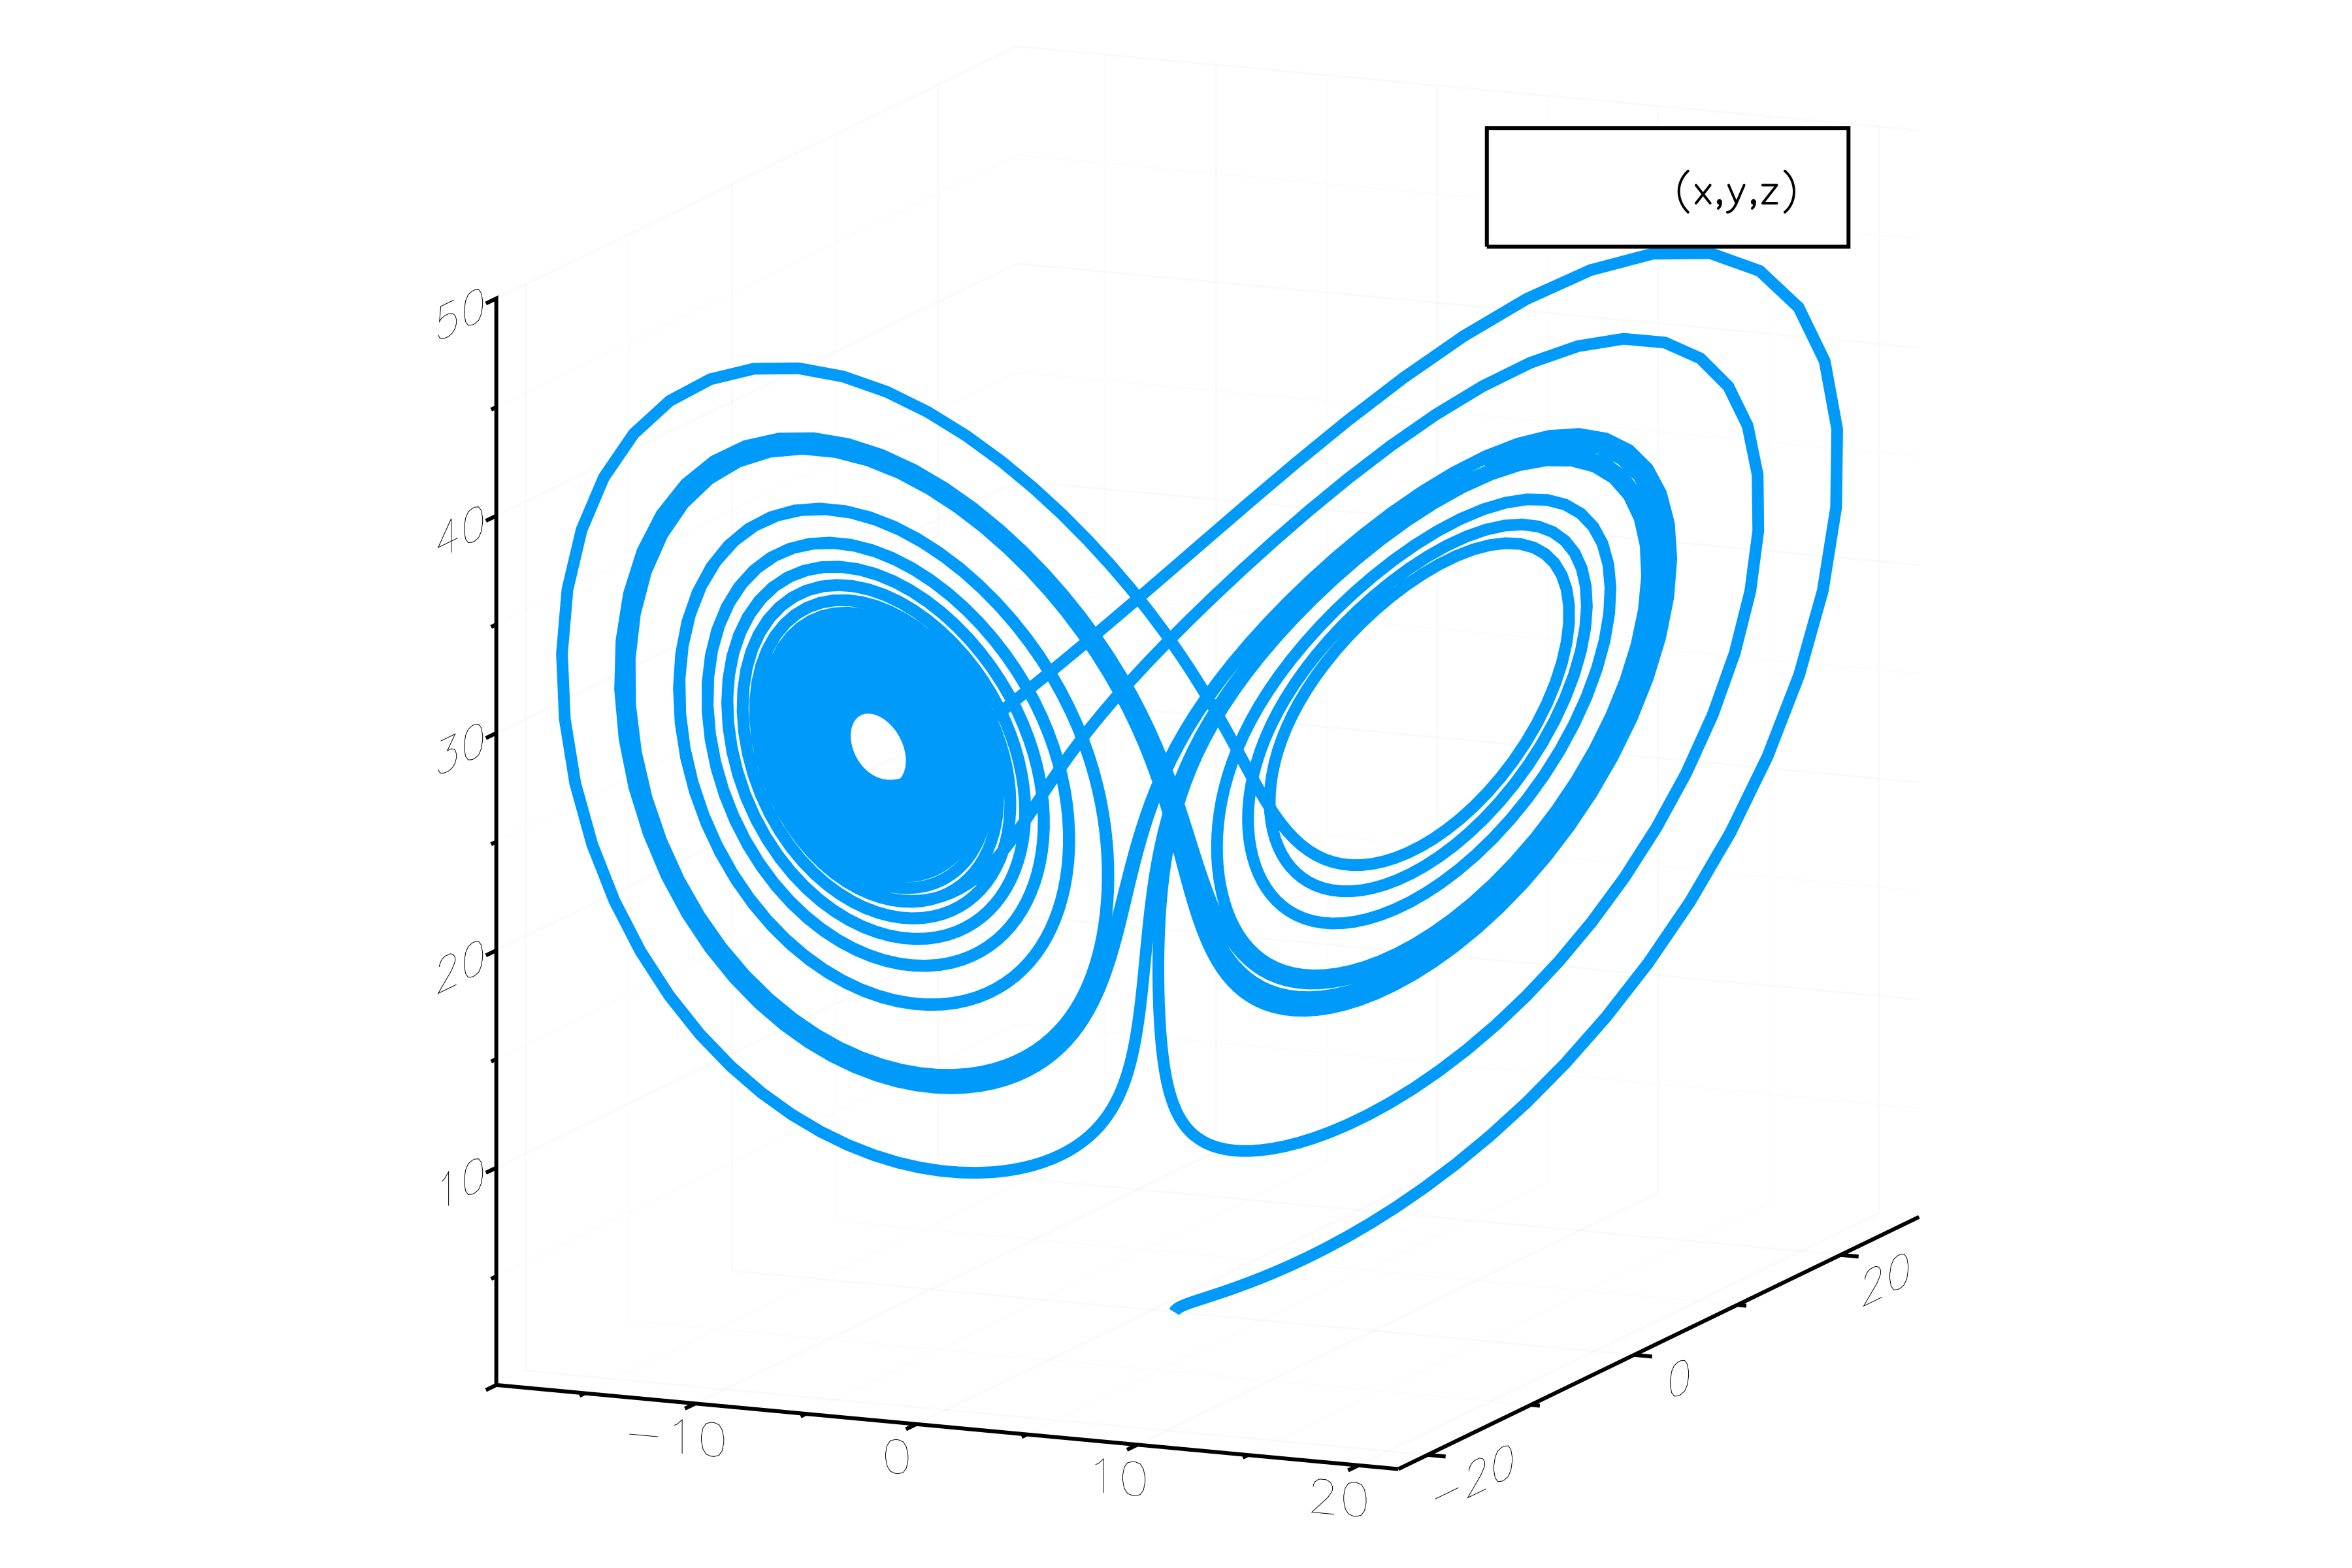

In [17]:
plot(data_sol_short,vars=(1,2,3)) # the short solution
plot(data_sol,vars=(1,2,3)) # the longer solution
interpolation_sol = solve(prob,Vern7(),saveat=t,reltol=1e-12,abstol=1e-12)
plot(interpolation_sol,vars=(1,2,3))


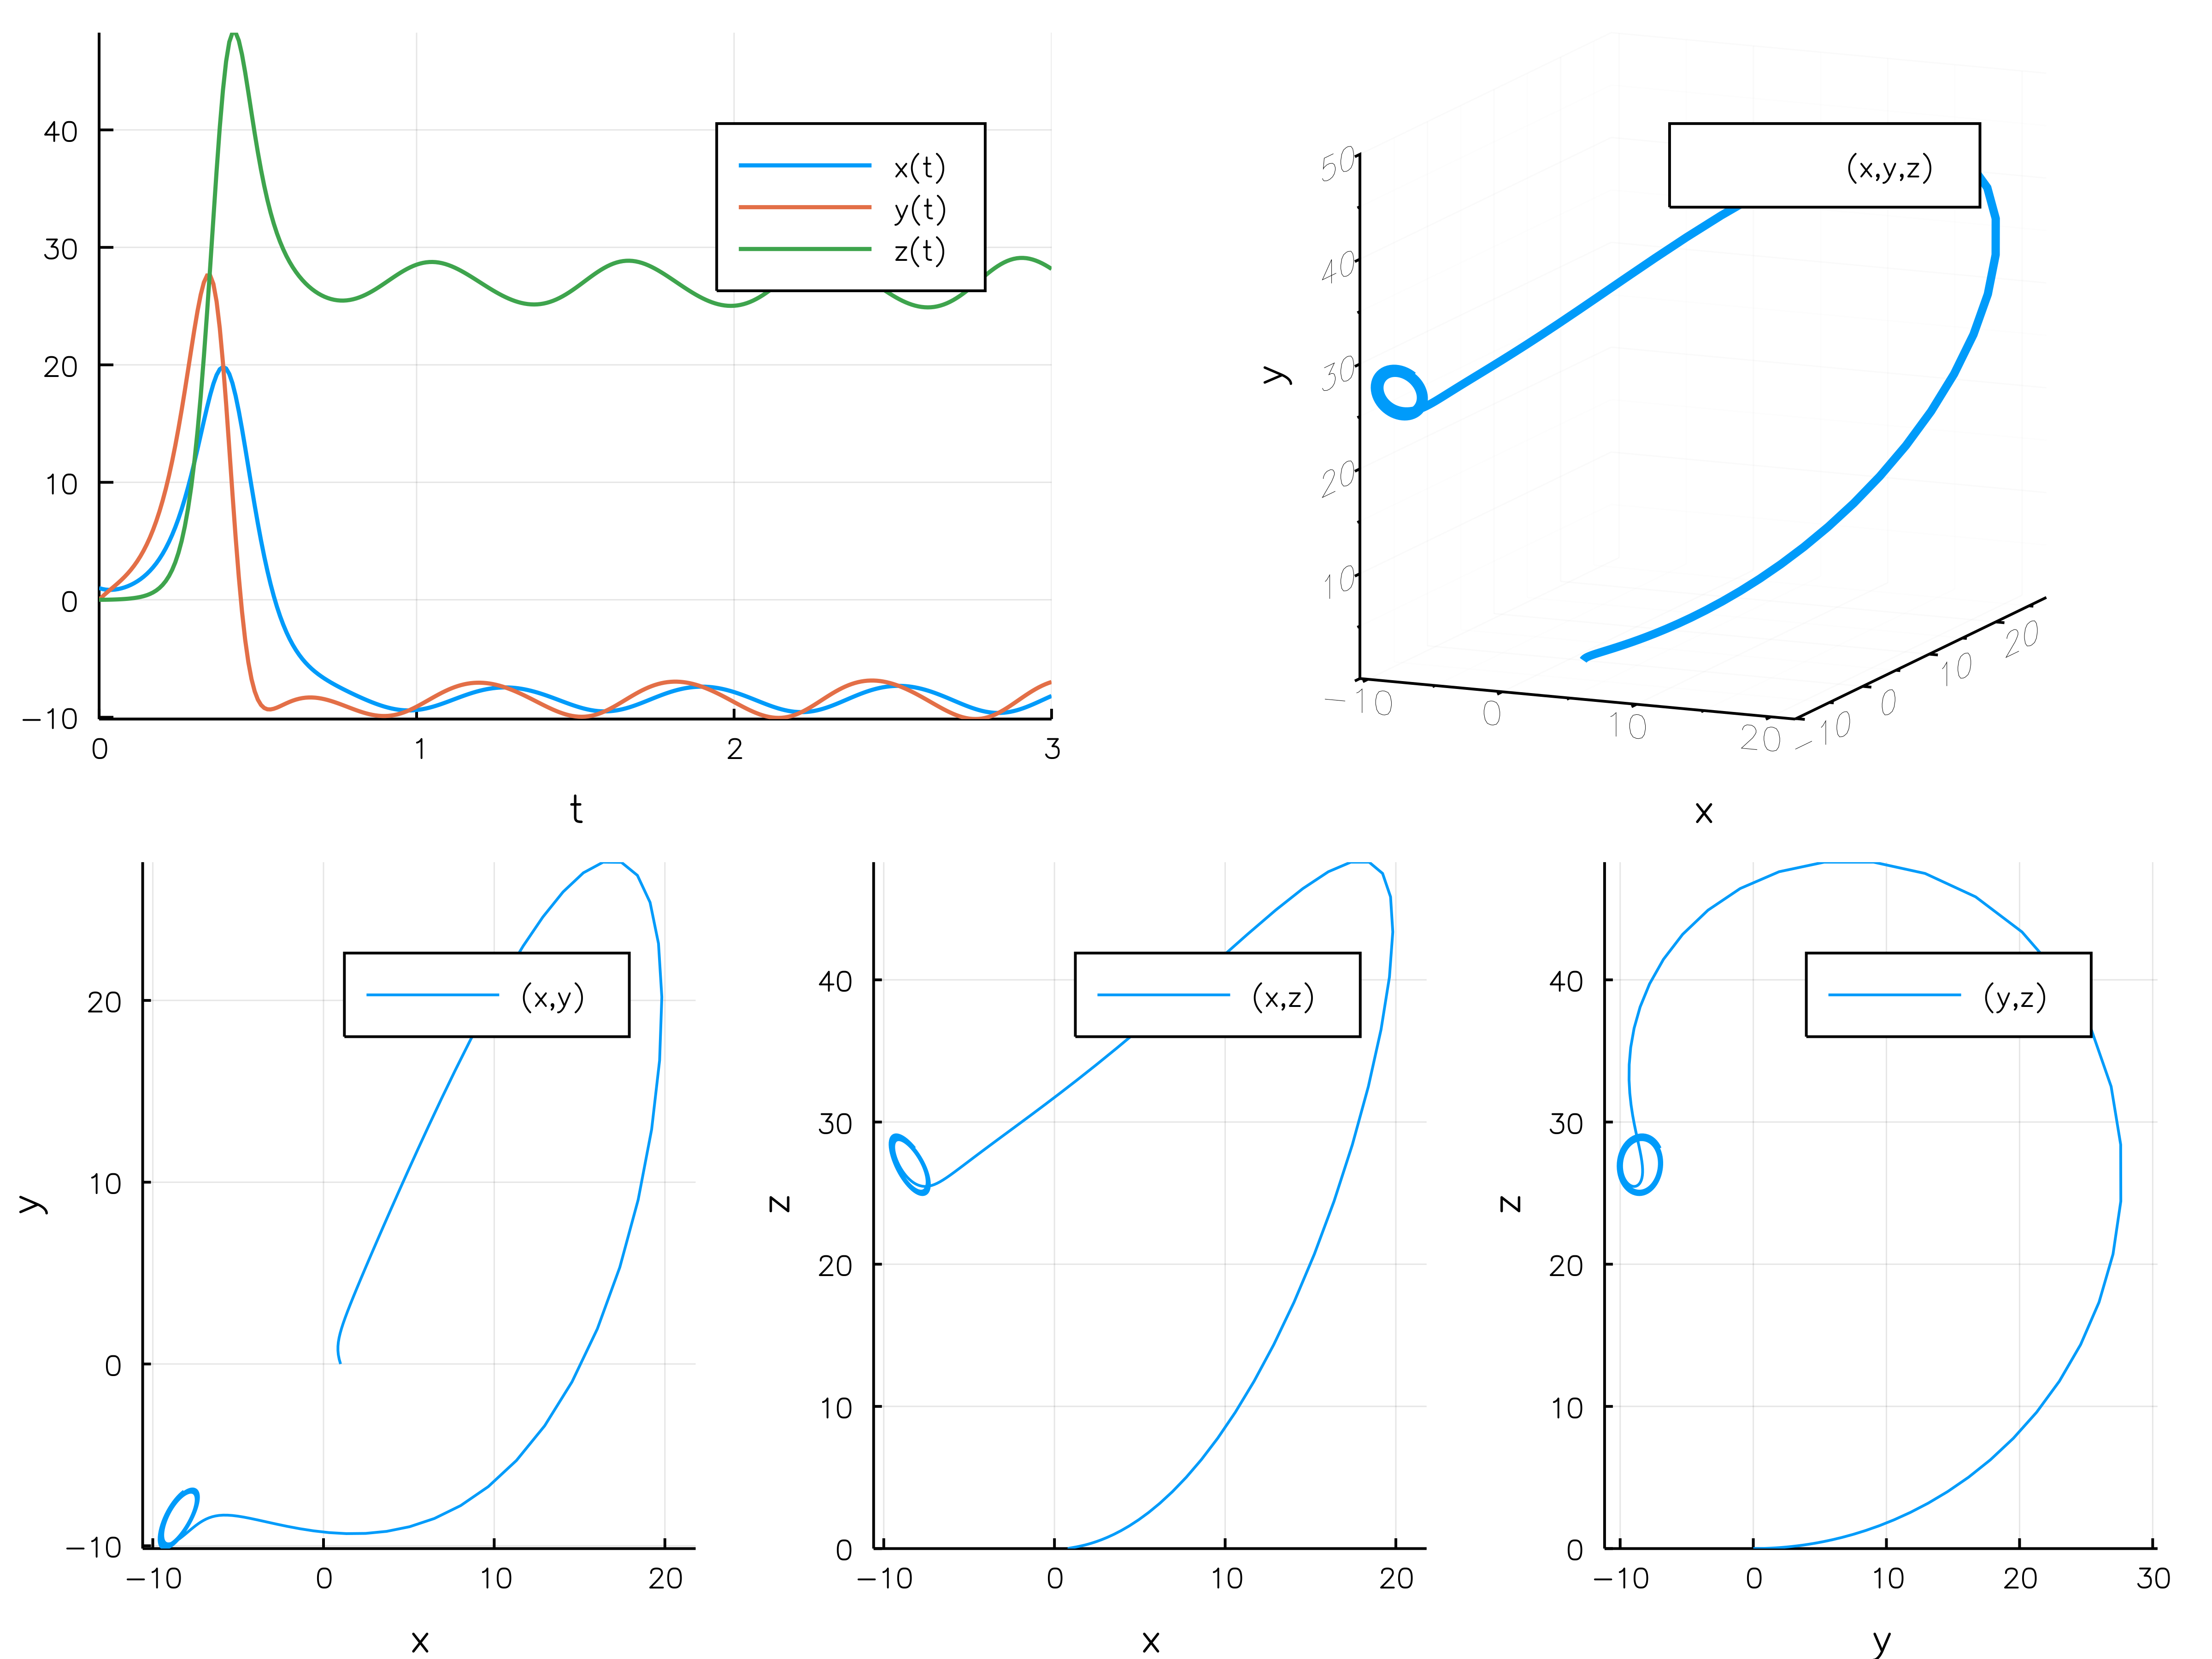

In [18]:
xyzt = plot(data_sol_short, plotdensity=10000,lw=1.5)
xy = plot(data_sol_short, plotdensity=10000, vars=(:x,:y))
xz = plot(data_sol_short, plotdensity=10000, vars=(:x,:z))
yz = plot(data_sol_short, plotdensity=10000, vars=(:y,:z))
xyz = plot(data_sol_short, plotdensity=10000, vars=(:x,:y,:z))
plot(plot(xyzt,xyz),plot(xy, xz, yz, layout=(1,3),w=1), layout=(2,1), size=(800,600))


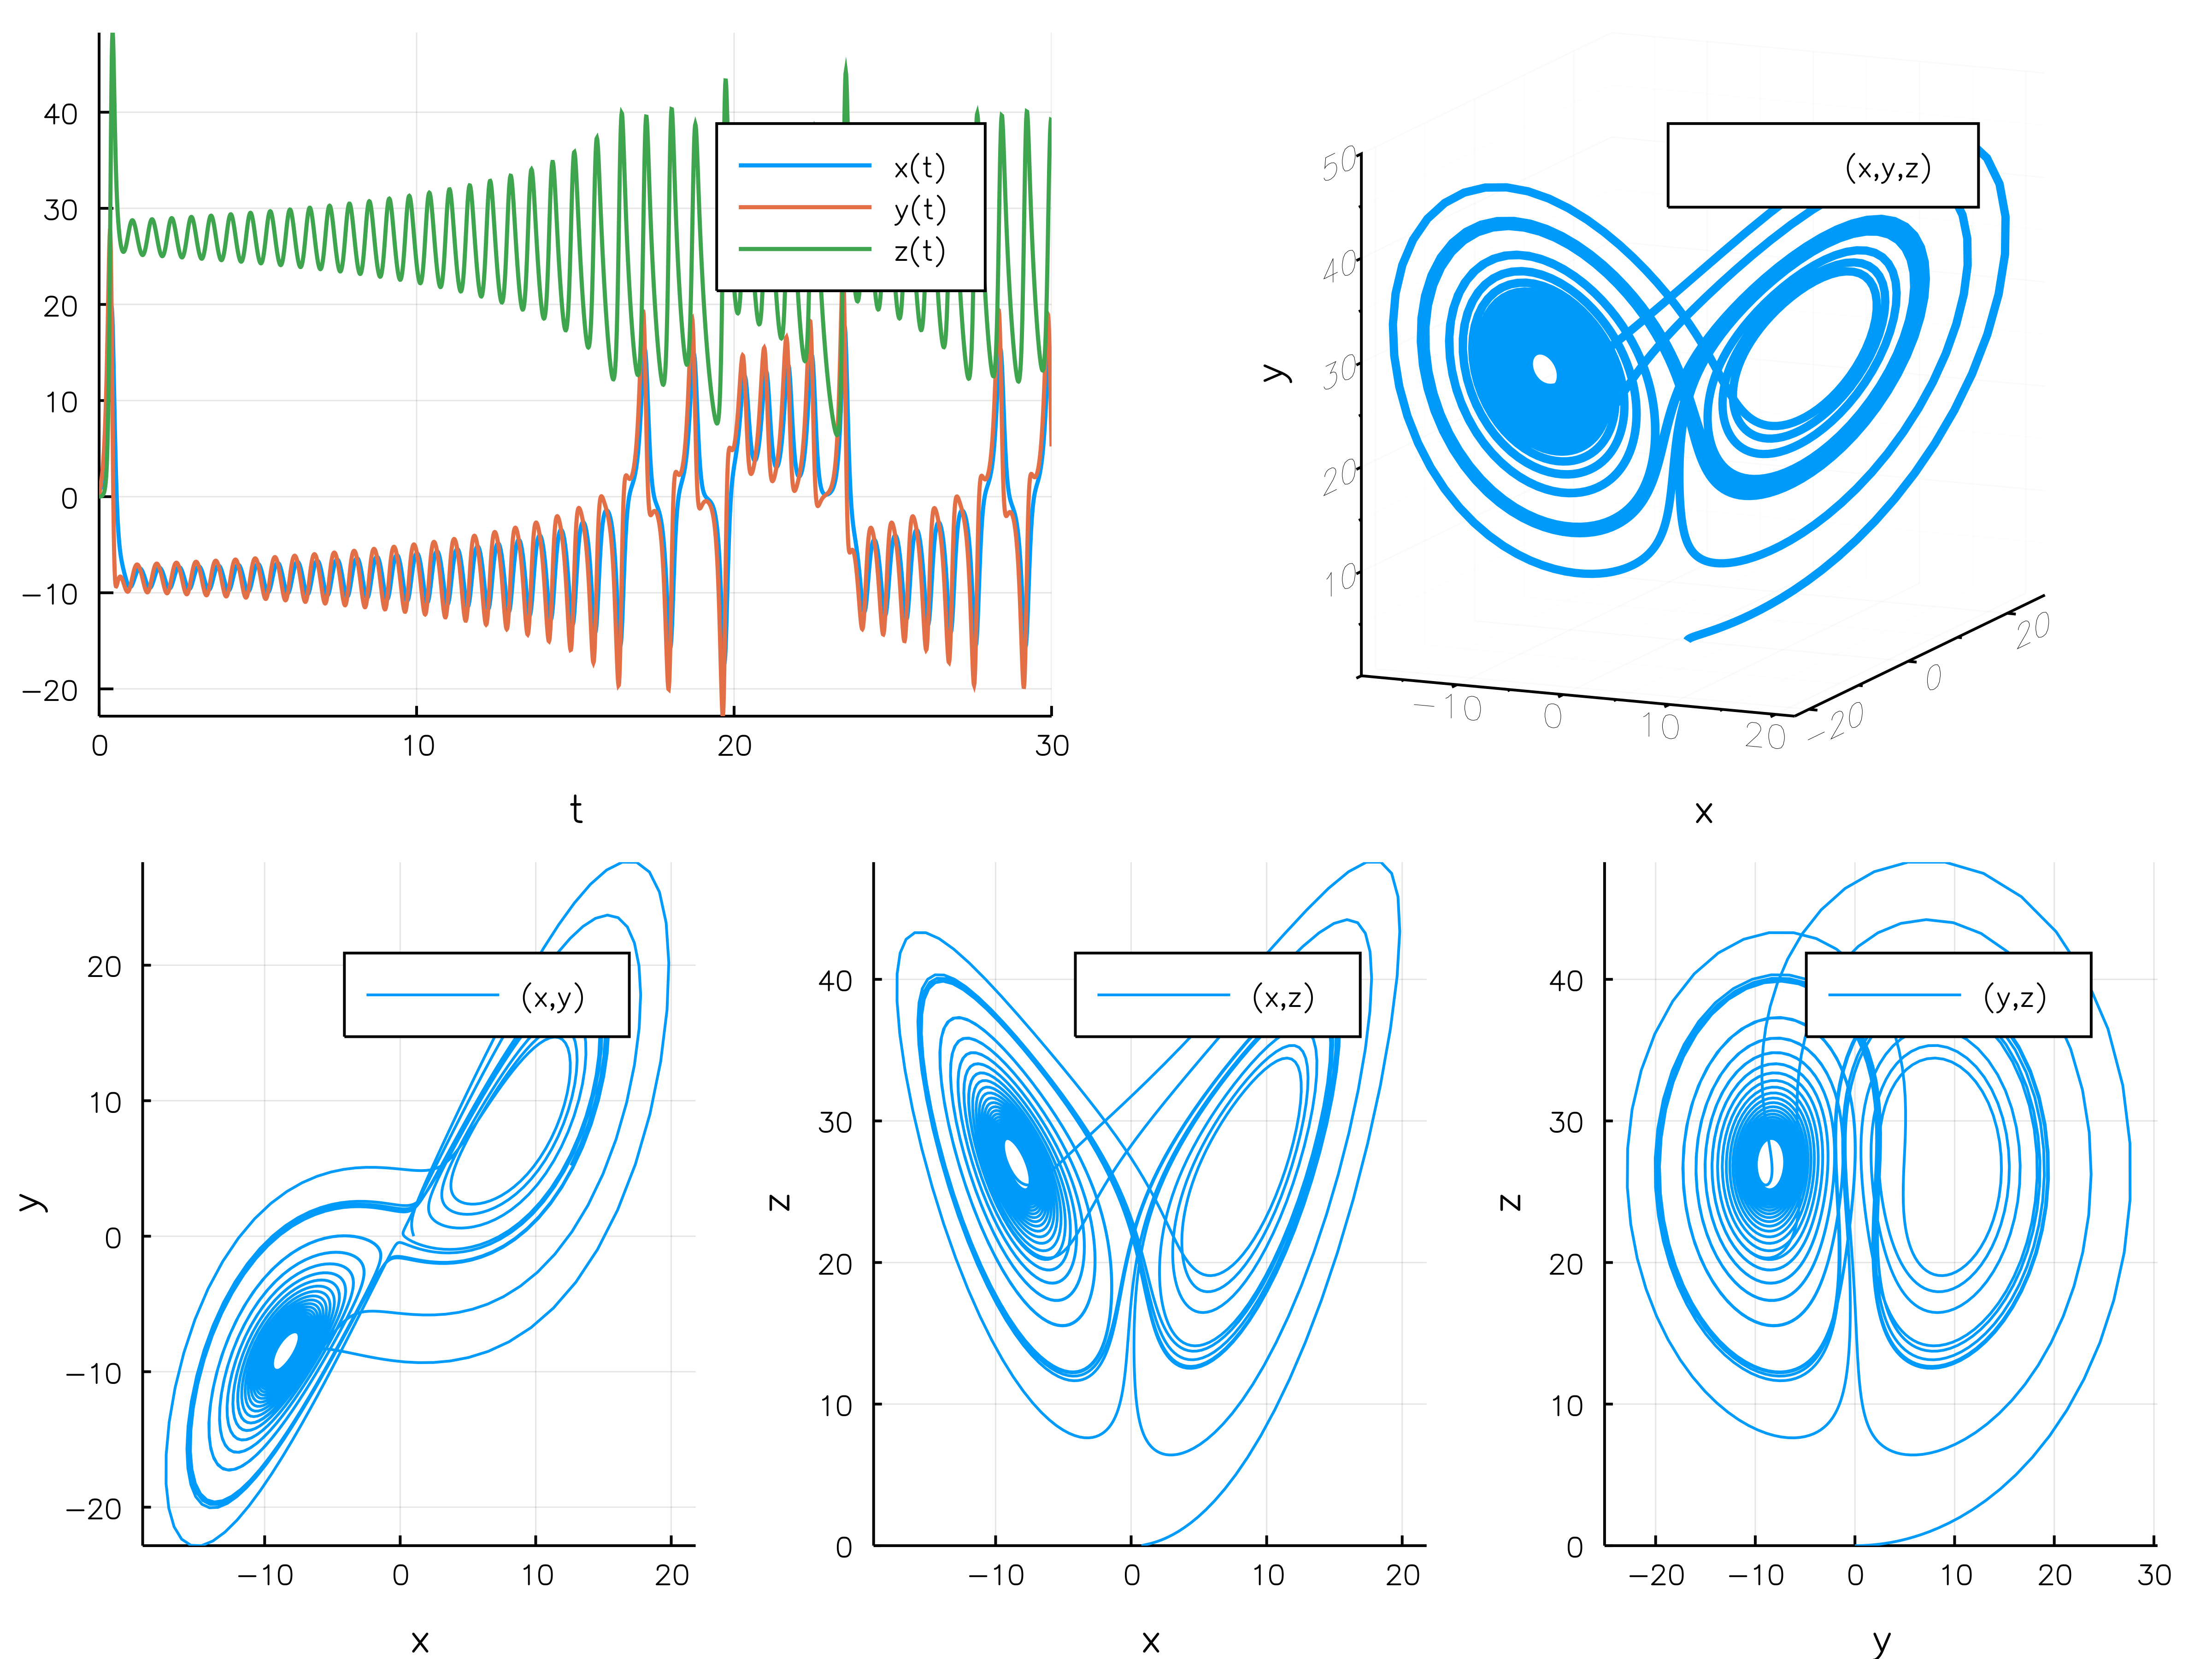

In [19]:
xyzt = plot(data_sol, plotdensity=10000,lw=1.5)
xy = plot(data_sol, plotdensity=10000, vars=(:x,:y))
xz = plot(data_sol, plotdensity=10000, vars=(:x,:z))
yz = plot(data_sol, plotdensity=10000, vars=(:y,:z))
xyz = plot(data_sol, plotdensity=10000, vars=(:x,:y,:z))
plot(plot(xyzt,xyz),plot(xy, xz, yz, layout=(1,3),w=1), layout=(2,1), size=(800,600))

## Find a local solution for the three parameters from a short data set

In [11]:
obj_short = build_loss_objective(prob_short,Tsit5(),L2Loss(t_short,data_short),tstops=t_short)
res1 = bboptimize(obj_short;SearchRange = LooserBounds, MaxSteps = 7e3)
# Tolernace is still too high to get close enough

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 552 evals, 402 steps, improv/step: 0.313 (last = 0.3134), fitness=6716.326361610
1.00 secs, 1202 evals, 1048 steps, improv/step: 0.293 (last = 0.2802), fitness=321.702484357
1.50 secs, 1896 evals, 1743 steps, improv/step: 0.283 (last = 0.2676), fitness=10.934223374
2.01 secs, 2582 evals, 2429 steps, improv/step: 0.284 (last = 0.2872), fitness=0.250119100
2.51 secs, 3271 evals, 3119 steps, improv/step: 0.289 (last = 0.3072), fitness=0.014049874
3.01 secs, 3960 evals, 3810 steps, improv/step: 0.291 (last = 0.2996), fitness=0.000606500
3.51 secs, 4649 evals, 4499 steps, improv/step: 0.295 (last = 0.3179), fitness=0.000015720
4.01 secs, 5336 evals, 5186 steps, improv/step: 0.295 (last = 0.2969), fitness=0.000000547


BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (7000) reached", 7001, 1.516009579208e9, 5.325000047683716, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:RngSeed, 877408),Pair{Symbol,Any}(:SearchRange, Tuple{Float64,Float64}[(0.0, 22.0), (0.0, 60.0), (0.0, 6.0)]),Pair{Symbol,Any}(:MaxSteps, 7000)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:FitnessScheme, BlackBoxOptim.ScalarFitnessScheme{true}()),Pair{Symbol,Any}(:NumDimensions, :NotSpecified),Pair{Symbol,Any}(:PopulationSize, 50),Pair{Symbol,Any}(:MaxTime, 0.0),Pair{Symbol,Any}(:SearchRange, (-1.0, 1.0)),Pair{Symbol,Any}(:Method, :adaptive_de_rand_1_bin_radiuslimited),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals, 100),Pair{Symbol,Any}(:RngSeed, 1234),Pair{Symbol,Any}(:MaxFuncEvals, 0),Pair{Symbol,Any}(:SaveTrace, false)…)], 7151, BlackBoxOptim.ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,A

In [12]:
obj_short = build_loss_objective(prob_short,Tsit5(),L2Loss(t_short,data_short),tstops=t_short,reltol=1e-9)
res1 = bboptimize(obj_short;SearchRange = LooserBounds, MaxSteps = 7e3)
# With the tolerance lower, it achieves the correct solution in 3.5 seconds.

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 547 evals, 437 steps, improv/step: 0.339 (last = 0.3387), fitness=756.296146700
1.00 secs, 1038 evals, 927 steps, improv/step: 0.313 (last = 0.2898), fitness=103.680126366
1.51 secs, 1496 evals, 1385 steps, improv/step: 0.287 (last = 0.2336), fitness=11.483581187
2.01 secs, 2015 evals, 1904 steps, improv/step: 0.288 (last = 0.2909), fitness=3.929016787
2.52 secs, 2570 evals, 2459 steps, improv/step: 0.289 (last = 0.2937), fitness=0.086793633
3.02 secs, 3116 evals, 3006 steps, improv/step: 0.293 (last = 0.3090), fitness=0.002534761
3.52 secs, 3672 evals, 3563 steps, improv/step: 0.293 (last = 0.2944), fitness=0.000480736
4.02 secs, 4226 evals, 4117 steps, improv/step: 0.289 (last = 0.2617), fitness=0.000085094
4.

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (7000) reached", 7001, 1.516009598509e9, 6.658999919891357, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:RngSeed, 105042),Pair{Symbol,Any}(:SearchRange, Tuple{Float64,Float64}[(0.0, 22.0), (0.0, 60.0), (0.0, 6.0)]),Pair{Symbol,Any}(:MaxSteps, 7000)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:FitnessScheme, BlackBoxOptim.ScalarFitnessScheme{true}()),Pair{Symbol,Any}(:NumDimensions, :NotSpecified),Pair{Symbol,Any}(:PopulationSize, 50),Pair{Symbol,Any}(:MaxTime, 0.0),Pair{Symbol,Any}(:SearchRange, (-1.0, 1.0)),Pair{Symbol,Any}(:Method, :adaptive_de_rand_1_bin_radiuslimited),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals, 100),Pair{Symbol,Any}(:RngSeed, 1234),Pair{Symbol,Any}(:MaxFuncEvals, 0),Pair{Symbol,Any}(:SaveTrace, false)…)], 7109, BlackBoxOptim.ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,A

In [13]:
obj_short = build_loss_objective(prob_short,Vern9(),L2Loss(t_short,data_short),tstops=t_short,reltol=1e-9,abstol=1e-9)
res1 = bboptimize(obj_short;SearchRange = LooserBounds, MaxSteps = 7e3)
# With the more accurate solver Vern9 in the solution of the ODE, the convergence is less efficient!

# Fastest BlackBoxOptim: 3.5 seconds

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 622 evals, 519 steps, improv/step: 0.362 (last = 0.3622), fitness=635.844639846
1.00 secs, 1228 evals, 1125 steps, improv/step: 0.316 (last = 0.2772), fitness=18.213355891
1.50 secs, 1843 evals, 1741 steps, improv/step: 0.310 (last = 0.2987), fitness=0.417039337
2.01 secs, 2459 evals, 2357 steps, improv/step: 0.297 (last = 0.2597), fitness=0.021587630
2.51 secs, 3072 evals, 2970 steps, improv/step: 0.288 (last = 0.2545), fitness=0.001723951
3.01 secs, 3690 evals, 3588 steps, improv/step: 0.288 (last = 0.2848), fitness=0.000323200
3.51 secs, 4305 evals, 4203 steps, improv/step: 0.286 (last = 0.2732), fitness=0.000013792
4.01 secs, 4924 evals, 4822 steps, improv/step: 0.288 (last = 0.3021), fitness=0.000000950
4.5

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (7000) reached", 7001, 1.516009612675e9, 5.903000116348267, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:RngSeed, 69609),Pair{Symbol,Any}(:SearchRange, Tuple{Float64,Float64}[(0.0, 22.0), (0.0, 60.0), (0.0, 6.0)]),Pair{Symbol,Any}(:MaxSteps, 7000)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:FitnessScheme, BlackBoxOptim.ScalarFitnessScheme{true}()),Pair{Symbol,Any}(:NumDimensions, :NotSpecified),Pair{Symbol,Any}(:PopulationSize, 50),Pair{Symbol,Any}(:MaxTime, 0.0),Pair{Symbol,Any}(:SearchRange, (-1.0, 1.0)),Pair{Symbol,Any}(:Method, :adaptive_de_rand_1_bin_radiuslimited),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals, 100),Pair{Symbol,Any}(:RngSeed, 1234),Pair{Symbol,Any}(:MaxFuncEvals, 0),Pair{Symbol,Any}(:SaveTrace, false)…)], 7103, BlackBoxOptim.ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Ar

# Using NLopt

First, the global optimization algorithms

In [14]:
obj_short = build_loss_objective(prob_short,Vern9(),L2Loss(t_short,data_short),tstops=t_short,reltol=1e-9,abstol=1e-9)

(::DiffEqObjective) (generic function with 2 methods)

In [15]:
opt = Opt(:GN_ORIG_DIRECT_L, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Accurate 3.2 seconds

  3.177196 seconds (18.55 M allocations: 828.775 MiB, 5.84% gc time)


(7.399386484909725e-18, [10.0, 28.0, 2.66], :XTOL_REACHED)

In [16]:
opt = Opt(:GN_CRS2_LM, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Accurate 3.0 seconds

  2.728951 seconds (16.14 M allocations: 721.363 MiB, 5.90% gc time)


(2.852927598467924e-18, [10.0, 28.0, 2.66], :XTOL_REACHED)

In [17]:
opt = Opt(:GN_ISRES, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Accurate to single precision 8.2 seconds

  8.101673 seconds (47.62 M allocations: 2.078 GiB, 5.55% gc time)


(0.0014260884142458603, [9.99928, 27.9999, 2.65975], :MAXEVAL_REACHED)

In [18]:
opt = Opt(:GN_ESCH, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Approximatively accurate, good starting values for local optimization

  8.145011 seconds (47.62 M allocations: 2.078 GiB, 5.71% gc time)


(238.30645522592377, [10.1912, 27.6588, 2.75838], :MAXEVAL_REACHED)

Next, the local optimization algorithms that could be used after the global algorithms as a check on the solution and its precision. All the local optimizers are started from LocIniPar and with the narrow bounds of the Xiang2015Paper. 

In [19]:
opt = Opt(:LN_BOBYQA, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # 0.1 seconds

  0.104445 seconds (523.83 k allocations: 23.408 MiB, 4.82% gc time)


(2.76954149411742e-18, [10.0, 28.0, 2.66], :XTOL_REACHED)

In [20]:
opt = Opt(:LN_NELDERMEAD, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.29 sec

  0.292511 seconds (1.56 M allocations: 69.599 MiB, 5.57% gc time)


(2.7730093540821814e-18, [10.0, 28.0, 2.66], :XTOL_REACHED)

In [21]:
opt = Opt(:LD_SLSQP, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.21 sec

  0.199501 seconds (852.77 k allocations: 38.189 MiB, 6.29% gc time)


(1.1112469462930288e-15, [10.0, 28.0, 2.66], :XTOL_REACHED)

In [22]:
opt = Opt(:LN_COBYLA, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 1.84 sec

  1.807022 seconds (10.34 M allocations: 461.971 MiB, 5.95% gc time)


(2.861949697593622e-18, [10.0, 28.0, 2.66], :XTOL_REACHED)

In [23]:
opt = Opt(:LN_NEWUOA_BOUND, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.18 sec ROUNDOFF LIMITED

  0.181245 seconds (742.88 k allocations: 33.196 MiB, 6.80% gc time)


(5.275299515678992e-10, [10.0, 28.0, 2.66], :SUCCESS)

In [24]:
opt = Opt(:LN_PRAXIS, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.18 sec

  0.174023 seconds (895.27 k allocations: 40.005 MiB, 6.60% gc time)


(2.809177227281428e-18, [10.0, 28.0, 2.66], :SUCCESS)

In [25]:
opt = Opt(:LN_SBPLX, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.65 sec

  0.627672 seconds (3.56 M allocations: 159.169 MiB, 5.70% gc time)


(2.7849937877089793e-18, [10.0, 28.0, 2.66], :XTOL_REACHED)

In [26]:
opt = Opt(:LD_MMA, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.7 sec

  0.683145 seconds (3.90 M allocations: 174.234 MiB, 6.04% gc time)


(2.4876525761108884e-16, [10.0, 28.0, 2.66], :XTOL_REACHED)

In [27]:
opt = Opt(:LD_LBFGS, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.12 sec

  0.122369 seconds (599.95 k allocations: 26.806 MiB, 5.81% gc time)


(1.1160630883835927e-15, [10.0, 28.0, 2.66], :SUCCESS)

In [28]:
opt = Opt(:LD_TNEWTON_PRECOND_RESTART, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.15 sec

  0.155022 seconds (766.60 k allocations: 34.252 MiB, 8.19% gc time)


(1.1162058847408525e-15, [10.0, 28.0, 2.66], :SUCCESS)


## Now let's solve the longer version for a global solution

Notice from the plotting above that this ODE problem is chaotic and tends to diverge over time. In the longer version of parameter estimation, the dataset is increased to 3000 observations per variable with the same integration time step of 0.01.
Vern9 solver with reltol=1e-9 and abstol=1e-9 has been established to be accurate on the time interval [0,50]

In [32]:
# BB with Vern9 converges very slowly. The final values are within the NarrowBounds.
obj = build_loss_objective(prob,Vern9(),L2Loss(t,data),tstops=t,reltol=1e-9,abstol=1e-9)

res1 = bboptimize(obj;SearchRange = LooserBounds, MaxSteps = 4e3) # Default adaptive_de_rand_1_bin_radiuslimited 33 sec [10.2183, 24.6711, 2.28969]
#res1 = bboptimize(obj;SearchRange = LooserBounds, Method = :adaptive_de_rand_1_bin, MaxSteps = 4e3) # Method 32 sec [13.2222, 25.8589, 2.56176]
#res1 = bboptimize(obj;SearchRange = LooserBounds, Method = :dxnes, MaxSteps = 2e3) # Method dxnes 119 sec  [16.8648, 24.393, 2.29119]
#res1 = bboptimize(obj;SearchRange = LooserBounds, Method = :xnes, MaxSteps = 2e3) # Method xnes 304 sec  [19.1647, 24.9479, 2.39467]
#res1 = bboptimize(obj;SearchRange = LooserBounds, Method = :de_rand_1_bin_radiuslimited, MaxSteps = 2e3) # Method 44 sec  [13.805, 24.6054, 2.37274]
#res1 = bboptimize(obj;SearchRange = LooserBounds, Method = :generating_set_search, MaxSteps = 2e3) # Method 195 sec [19.1847, 24.9492, 2.39412]

Starting optimization with optimizer BlackBoxOptim.DXNESOpt{Float64,BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
σ=1.0 η[x]=1.0 η[σ]=0.0 η[B]=0.0 |tr(ln_B)|=8.881784197001252e-16 |path|=0.0 speed=0.0
0.53 secs, 56 evals, 8 steps, fitness=607974.313059148
σ=0.3697861588719081 η[x]=1.0 η[σ]=0.7692307692307692 η[B]=0.056 |tr(ln_B)|=1.1102230246251565e-15 |path|=1.9253531076025812 speed=0.6878181419793957
1.04 secs, 119 evals, 17 steps, fitness=532754.572944665
σ=0.6450166499262784 η[x]=1.0 η[σ]=0.7692307692307692 η[B]=0.056 |tr(ln_B)|=1.2212453270876722e-15 |path|=0.9174074326878715 speed=0.32773701265384103
1.55 secs, 182 evals, 26 steps, fitness=527505.698751140
σ=0.15658991602931807 η[x]=1.0 η[σ]=0.7692307692307692 η[B]=0.056 |tr(ln_B)|=1.2212453270876722e-15 |path|=1.8905823597648288 speed=0.6753965497641492
2.06 secs, 245 evals, 35 steps, fitness=527505.698751140
σ=0.03320262694133043 η[x]=1.0 η[σ]=0.7692307692307692 η[B]=0.056 |tr(ln_B

BlackBoxOptim.OptimizationResults("dxnes", "Max number of steps (2000) reached", 2001, 1.516010076532e9, 119.12100005149841, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:RngSeed, 737015),Pair{Symbol,Any}(:SearchRange, Tuple{Float64,Float64}[(0.0, 22.0), (0.0, 60.0), (0.0, 6.0)]),Pair{Symbol,Any}(:Method, :dxnes),Pair{Symbol,Any}(:MaxSteps, 2000)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:FitnessScheme, BlackBoxOptim.ScalarFitnessScheme{true}()),Pair{Symbol,Any}(:NumDimensions, :NotSpecified),Pair{Symbol,Any}(:PopulationSize, 50),Pair{Symbol,Any}(:MaxTime, 0.0),Pair{Symbol,Any}(:SearchRange, (-1.0, 1.0)),Pair{Symbol,Any}(:Method, :adaptive_de_rand_1_bin_radiuslimited),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals, 100),Pair{Symbol,Any}(:RngSeed, 1234),Pair{Symbol,Any}(:MaxFuncEvals, 0),Pair{Symbol,Any}(:SaveTrace, false)…)], 14007, BlackBoxOptim.ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Floa

In [31]:
# using Evolutionary
# N = 3
# @time result, fitness, cnt = cmaes(obj, N; μ = 3, λ = 12, iterations = 1000) # cmaes( rastrigin, N; μ = 15, λ = P, tol = 1e-8)

In [33]:
opt = Opt(:GN_ORIG_DIRECT_L, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Fail to converge 

 14.938654 seconds (101.87 M allocations: 3.651 GiB, 5.28% gc time)


(470363.2181996153, [7.04676, 23.6656, 1.80658], :XTOL_REACHED)

In [36]:
opt = Opt(:GN_CRS2_LM, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 20000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Hit and miss. converge approximately accurate values for local opt.91 seconds

153.596003 seconds (1.06 G allocations: 37.816 GiB, 5.30% gc time)


(525967.3577305243, [19.1637, 24.9451, 2.39478], :MAXEVAL_REACHED)

In [35]:
opt = Opt(:GN_ISRES, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 50000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Approximately accurate within local bounds

389.922834 seconds (2.64 G allocations: 94.539 GiB, 5.63% gc time)


(457440.01339330774, [9.2112, 27.0372, 2.223], :MAXEVAL_REACHED)

In [37]:
opt = Opt(:GN_ESCH, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 20000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Approximately accurate

166.449863 seconds (1.06 G allocations: 37.816 GiB, 5.59% gc time)


(452355.1761286359, [9.23828, 26.8303, 2.27546], :MAXEVAL_REACHED)

This parameter estimation on the longer sample proves to be extremely challenging for the global optimizers. BlackBoxOptim is best in optimizing the objective function. All of the global algorithms produces final parameter estimates that could be used as starting values for further refinement with the local optimization algorithms.

In [56]:
opt = Opt(:LN_BOBYQA, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Claims SUCCESS but does not iterate to the true values.

  2.266360 seconds (5.70 M allocations: 209.106 MiB, 2.40% gc time)


(588301.876527702, [9.86631, 20.5815, 2.0], :SUCCESS)

In [57]:
opt = Opt(:LN_NELDERMEAD, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-9)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Inaccurate final values

  3.962906 seconds (9.65 M allocations: 354.319 MiB, 2.02% gc time)


(439664.3609672592, [9.9937, 23.2594, 2.15897], :XTOL_REACHED)

In [58]:
opt = Opt(:LD_SLSQP, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Inaccurate final values

  1.227923 seconds (3.01 M allocations: 110.359 MiB, 2.07% gc time)


(591291.6479752676, [9.1791, 20.6017, 2.0338], :XTOL_REACHED)

No local optimizer can improve the global solution to the true values.

# Conclusion:


 1) As expected the Lorenz system is extremely sensitive to initial space values. Starting the integration from `r0 = [0.1,0.0,0.0]` produces convergence with the short sample of 300 observations. This can be achieved by all the global optimizers as well as most of the local   optimizers. Instead starting from `r0= [-11.8,-5.1,37.5]`, as in PODES, with the shorter sample shrinks the number of successful algorithms to 3: `BBO`, `:GN_CRS2_LM `and `:LD_SLSQP`. For the longer sample, all the algorithms fail.
    
 2) When trying to hit the real data, having a low enough tolerance on the numerical solution is key. If the numerical solution is too rough, then we can never actually hone in on the true parameters since even with the true parameters we will erroneously induce numerical error. Maybe this could be adaptive?
    
 3) Excessively low tolerance in the numerical solution is inefficient and delays the convergence of the estimation.
 
 4) The estimation method and the glocal versus local optimization make a huge difference in the timings. Here, BBO always find the correct solution for a global optimization setup. For local optimization, most methods in     NLopt, like :LN_BOBYQA, solve the problem in <0.05 seconds. This is an algorithm that can scale a local optimization but we are aiming to scale a global optimization.
    
 5) Fitting shorter timespans is easier... maybe this can lead to determining a minimal sample size for the optimizers and the estimator to succeed.